In [1]:
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt

data_dir = '/Users/mbedell/python/pmodes/experiments/data/'

In [2]:
tbl = ascii.read(data_dir+'betahyi_rvs.txt', delimiter='|', guess=False, data_start=2)

In [3]:
t, rv, err = tbl['bjd'], tbl['rv']*1.e3, tbl['err_rv']*1.e3
rv -= np.mean(rv)
t -= np.min(t)
ss = np.argsort(t)
t = t[ss]
rv = rv[ss]
err = err[ss]

In [4]:
bad = (err >= 500.)
np.sum(bad)

69

In [5]:
t = t[~bad]
rv = rv[~bad]

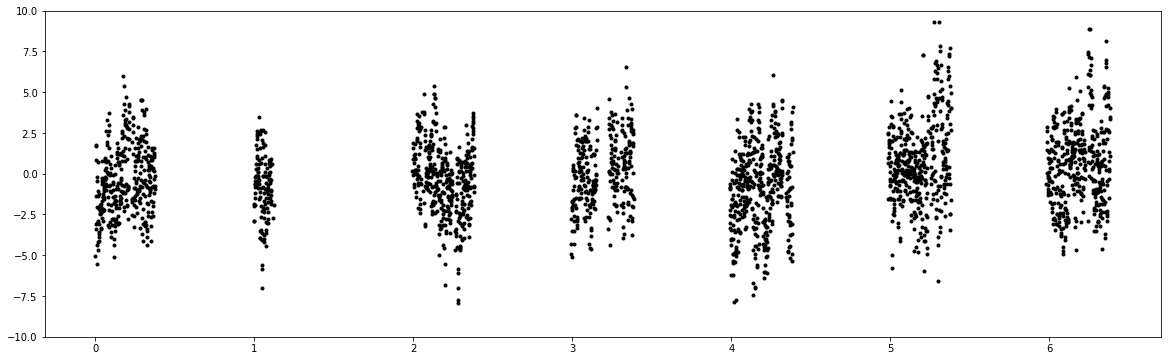

In [6]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(t,rv, 'k.')
ax.set_ylim([-10,10]);

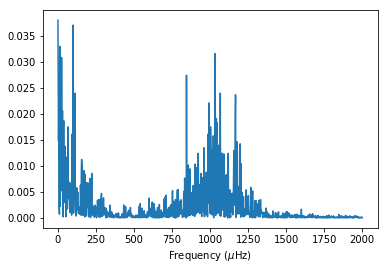

In [7]:
from astropy.stats import LombScargle
frequency = np.linspace(1e-6, 2000e-6, 1000)
power = LombScargle(t * 24 * 3600, rv).power(frequency)
plt.plot(frequency*1e6, power)
plt.xlabel(r'Frequency ($\mu$Hz)');

Subtract off nightly trends:

In [8]:
from scipy.optimize import curve_fit

In [9]:
def fn(xs, a, b, c):
    # degree 3 polynomial
    return a*xs**2 + b*xs + c
    #return np.ones_like(xs) + c

In [10]:
rv_keep = np.copy(rv)
trend_xs = []
trend_ys = []
for i in range(7):
    night_inds = (t >= i-0.1) & (t <= i+0.5)
    coeffs = curve_fit(fn, t[night_inds], rv[night_inds])[0]
    plot_xs = np.linspace(i-0.1, i+0.5, 50)
    trend_xs.append(plot_xs)
    trend_ys.append(fn(plot_xs, *coeffs))
    rv[night_inds] -= fn(t[night_inds], *coeffs)

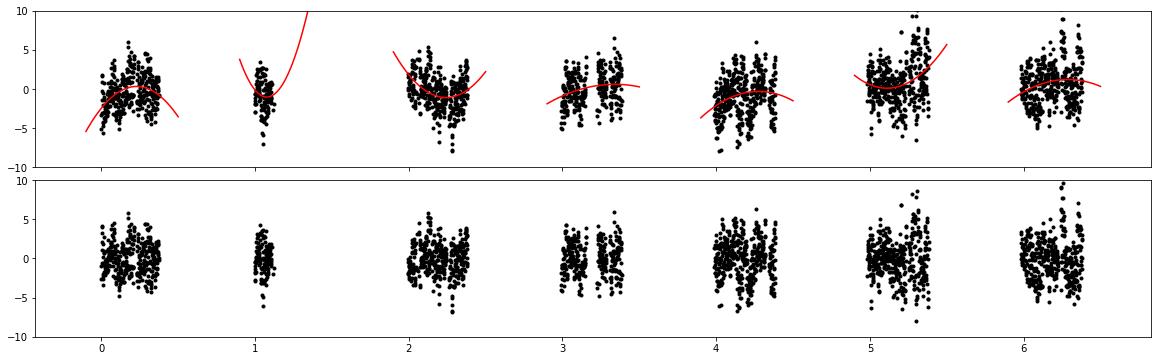

In [11]:
fig, (ax,ax2) = plt.subplots(2,1, figsize=(20, 6), sharex=True, sharey=True)
ax.plot(t,rv_keep, 'k.')
for i in range(7):
    ax.plot(trend_xs[i], trend_ys[i], c='r')
ax2.plot(t,rv, 'k.')
ax.set_ylim([-10,10])
fig.subplots_adjust(hspace=0.08);

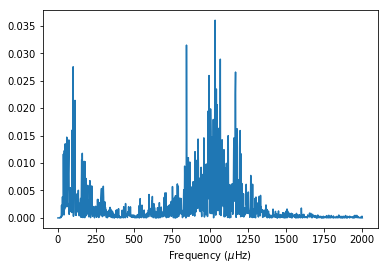

In [12]:
power = LombScargle(t * 24 * 3600, rv).power(frequency)
plt.plot(frequency*1e6, power)
plt.xlabel(r'Frequency ($\mu$Hz)');

Choose a single day to plot:

In [13]:
xrange = [4.95,5.4] # for plotting
inds = (t >= xrange[0]) & (t <= xrange[1])
t_short = t[inds]
rv_short = rv[inds]

Bin down the data on various intervals:

In [14]:
def bin_by_interval(xs, ys, interval):
    start_xs = np.arange(np.min(xs), np.max(xs), interval) # starting values of bins
    binned_xs, binned_ys = [], []
    for s in start_xs:
        e = s + interval
        inds = (xs >= s) & (xs < e)
        if np.sum(inds) > 0:
            binned_xs.append(np.median(xs[inds]))
            binned_ys.append(np.median(ys[inds]))
    return np.asarray(binned_xs), np.asarray(binned_ys)

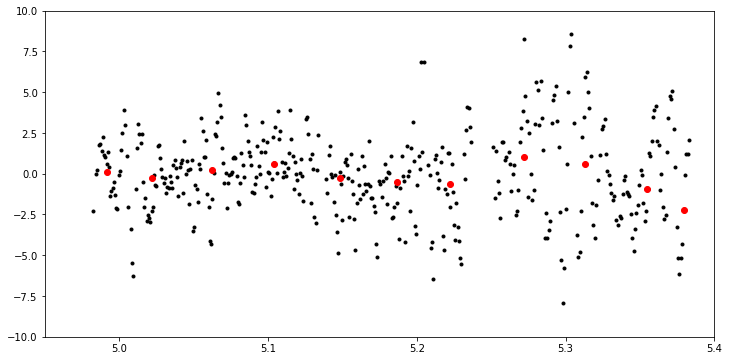

In [15]:
interval = 1./24. # 1 hr
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(t,rv, 'k.')
ax.plot(*bin_by_interval(t,rv,interval), 'r.', ms=12)
ax.set_ylim([-10,10])
ax.set_xlim(xrange);

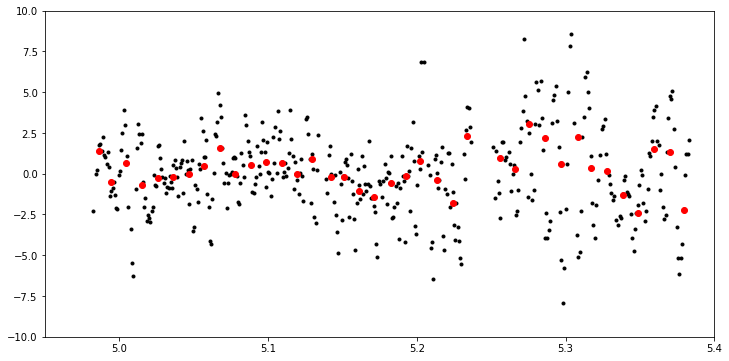

In [16]:
interval = 15./60./24. # 15 min
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(t,rv, 'k.')
ax.plot(*bin_by_interval(t,rv,interval), 'r.', ms=12)
ax.set_ylim([-10,10])
ax.set_xlim(xrange);

In [17]:
intervals = np.logspace(1.8,4.5,1000) # binning scale in seconds
rms = [np.std(bin_by_interval(t,rv,i/3600/24.)[1]) for i in intervals]
#rms_short = [np.std(bin_by_interval(t_short,rv_short,i/3600/24.)[1]) for i in intervals]

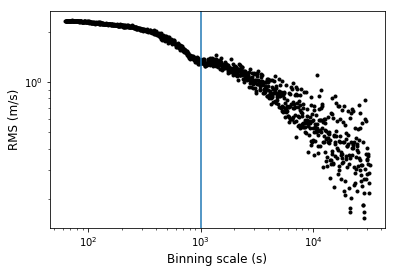

In [18]:
plt.loglog(intervals, rms, 'k.', ms=6)
#plt.loglog(intervals, rms_short, 'r.', ms=6, alpha=0.6)

plt.axvline(1.e3) # 1/nu-max, nu-max = 1 mHz
plt.xlabel('Binning scale (s)', fontsize=12)
plt.ylabel('RMS (m/s)', fontsize=12);

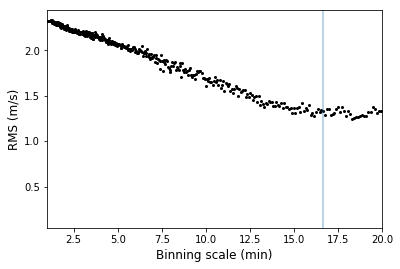

In [19]:
plt.plot(intervals/60, rms, 'k.', ms=4)
plt.axvline(1.e3/60, alpha=0.4) # 1/nu-max, nu-max = 1 mHz
plt.xlabel('Binning scale (min)', fontsize=12)
plt.ylabel('RMS (m/s)', fontsize=12)
plt.xlim([1,20]);

In [20]:
intervals = np.logspace(4.,4.5,1000) # binning scale in seconds
rms = [np.std(bin_by_interval(t,rv,i/3600/24.)[1]) for i in intervals]

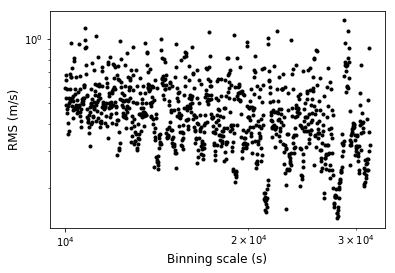

In [21]:
plt.loglog(intervals, rms, 'k.', ms=6)
plt.xlabel('Binning scale (s)', fontsize=12)
plt.ylabel('RMS (m/s)', fontsize=12);